# Terrain Classification - Window Size

### Created by Keenan McConkey on 2019.08.22

Imports all the types of preprocessed feature vectors for all the different window sizes, then trains/compares classifiers according to window size

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import sklearn
import numpy as np

#### Data Structure

`Dictionary of Feature Vectors
-> Dictionary of Placements
---> Dictionary of Window Sizes
-----> Dataframe of Processed Data`

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

# Dictionary of classifiers
classifiers = {'Naive Bayes': GaussianNB(),
               'k Nearest': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(), 
               'Random Forest': RandomForestClassifier(n_estimators=100),
               'AdaBoost': AdaBoostClassifier(),
               'Support Vector Machine': SVC(gamma='scale')}

In [3]:
# Change these to run over different parameters
# Note: Sizes should be changed for different placements, since they vary between Middle and the other 
#       placements due to difference in sampling rate
# TODO: Implement combined feature vectors similar to regular classification notebook
# TODO: Implement feature selection similar to regular classification notebook
PLACEMENTS = ['Middle']
VECTORS = ['TimeFeats', 'FreqFeats', 'FFTs', 'PSDLogs']
SIZES = [150, 300, 450, 600, 750, 900]

In [4]:
# Initialize data structure of imported data
sizes = {size: None for size in SIZES}
vectors = {vector: sizes for vector in VECTORS}
placements = {placement: vectors for placement in PLACEMENTS}

# For each .csv of processed data
for filename in glob.glob('processed_data/new_setup/new_normalization/manual/windows/*.csv'):
    _placement, _vector, _name, _size = filename.split('/')[-1].split('.')[0].split('_')
    
    # Continue if not in placements we want
    if _placement not in PLACEMENTS:
        continue
    
    data = pd.read_csv(filename)
    labels = data.pop('Label')
    
    # Save as tuple of data and labels
    placements[_placement][_vector][int(_size)] = (data, labels)

In [10]:
# Check dictionary data
placements['Middle']['TimeFeats'][450][0].head()

,MSF X Accel Middle,RMSF X Accel Middle,FC X Accel Middle,VF X Accel Middle,RVF X Accel Middle,MSF Y Accel Middle,RMSF Y Accel Middle,FC Y Accel Middle,VF Y Accel Middle,RVF Y Accel Middle,...,MSF Y Gyro Middle,RMSF Y Gyro Middle,FC Y Gyro Middle,VF Y Gyro Middle,RVF Y Gyro Middle,MSF Z Gyro Middle,RMSF Z Gyro Middle,FC Z Gyro Middle,VF Z Gyro Middle,RVF Z Gyro Middle
0,-0.280043,-0.249949,-0.259205,0.486346,-0.249949,-0.202810,0.015813,0.760320,-0.642025,0.015813,...,-0.284709,-0.343048,0.642206,-0.617144,-0.343048,-0.221912,0.004283,-0.358116,0.179065,0.004283
1,-0.296964,-0.309209,-0.190134,0.433947,-0.309209,-0.257703,-0.137252,0.084609,0.139429,-0.137252,...,-0.253338,-0.194188,0.679048,-0.673269,-0.194188,-0.399549,-0.253166,0.298480,0.045725,-0.253166
2,-0.129991,0.150617,0.569322,-0.312329,0.150617,-0.164084,0.110192,0.711468,-0.578141,0.110192,...,-0.163328,0.105735,0.712418,-0.724631,0.105735,-0.623974,-0.670189,-0.420125,0.186184,-0.670189
3,0.026981,0.457428,1.058304,-0.965047,0.457428,0.171247,0.713253,1.217490,-1.283882,0.713253,...,-0.150403,0.140965,0.740577,-0.768475,0.140965,-0.021661,0.253347,-0.106005,0.140127,0.253347
4,-0.073840,0.268808,1.197063,-1.178566,0.268808,-0.047307,0.353075,1.007677,-0.978119,0.353075,...,-0.184005,0.046320,0.846231,-0.936629,0.046320,-0.370061,-0.207262,-0.231276,0.161273,-0.207262


In [12]:
# Check dictionary labels
placements['Middle']['TimeFeats'][450][1]

0        3
1        3
2        3
3        3
4        3
        ..
10679    4
10680    4
10681    4
10682    4
10683    4
Name: Label, Length: 10684, dtype: int64

In [42]:
'''Run n-fold classifier training and testing on all placements, feature vectors, window sizes'''
def classify_sizes(cv_value=5):
    # Metric classifier dictionary
    _classifiers = {}
    
    for classifier_name, classifier in classifiers.items():
        # Go through each placement/vector/size
        _placements = {}
        
        for placement_name, placement in placements.items():
            _vectors = {}
            
            for vector_name, vector in placement.items():
                _sizes = {}
                
                for size_value, (size_data, size_labels) in vector.items():
                    # Init classifier model
                    model = classifier
                    
                    # Get preferred metric through mean of five cross validations
                    # Metrics = 'fit_time', 'score_time', 'test_score', 'train_score'
                    metrics = cross_validate(model, size_data, size_labels, cv=cv_value, 
                                                    return_train_score=True)
                    
                    _sizes.update({size_value: metrics})
                
                _vectors.update({vector_name: _sizes})
            
            _placements.update({placement_name: _vectors})
        
        _classifiers.update({classifier_name: _placements})
    
    return _classifiers

In [43]:
classifier_metrics = classify_sizes()

In [44]:
from joblib import dump, load

dump(classifier_metrics, 'dicts/Window_Size_Metric_Dict.joblib')

['dicts/Window_Size_Metric_Dict.joblib']

In [86]:
'''Plot given metric vs window size for given placement, feature vector, and classifiers'''
def plot_sizes(classifier_names, placement_names, vector_names, metric, cv_value=5):
    # Figure setup
    fig = plt.subplots(figsize=(10, 8))
    
    plt.xlabel('Window Size')
    if metric == 'test_score' or metric == 'train_score':
        plt.ylabel('Score (%)')
    elif metric == 'fit_time' or metric == 'score_time':
        plt.ylabel('Time (s)')
    plt.xticks(list(sizes.keys()))
    
    # Get title
    title = metric.split('_')[0].capitalize() + ' ' + metric.split('_')[1].capitalize()
    if 'Time' in title:
        title += ' (Across All Data)'
    plt.title('Window Size Comparision of ' + title)
    
    # Go through each of the given classifiers/placements/vectors
    for _classifier in classifier_names:
        for _placement in placement_names:
            for _vector in vector_names:
        
                # Retrieve size data of given classifier placement and vector
                _sizes = classifier_metrics[_classifier][_placement][_vector]
                plot_data = []
    
                # Plot mean of metric over multi fold testing
                for metrics in _sizes.values():
                    plot_data.append(np.mean(metrics[metric]))
                        
                # Plot window size vs plot data
                plt.plot(list(_sizes.keys()), plot_data, 
                         label=_classifier + ' ' + _placement + ' ' + _vector)
                
    plt.legend()
    plt.show()

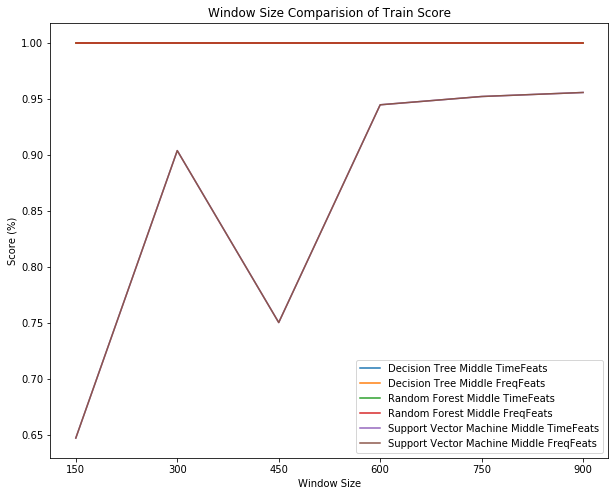

In [87]:
# Plot train score
plot_sizes(classifier_names=['Decision Tree', 'Random Forest', 'Support Vector Machine'],
           placement_names=PLACEMENTS, vector_names=['TimeFeats', 'FreqFeats'],
           metric='train_score')

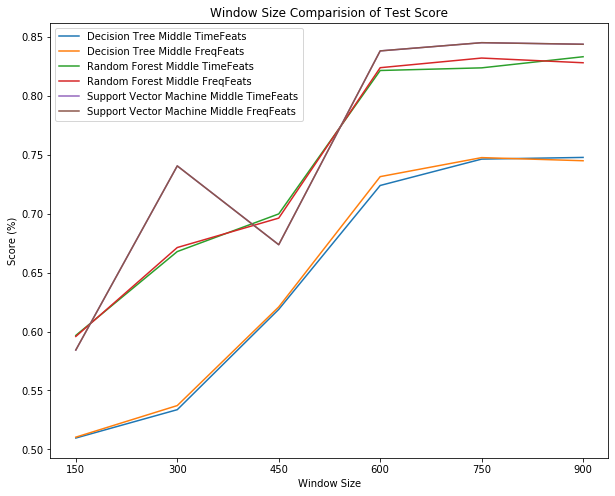

In [88]:
# Plot test score
plot_sizes(classifier_names=['Decision Tree', 'Random Forest', 'Support Vector Machine'],
           placement_names=PLACEMENTS, vector_names=['TimeFeats', 'FreqFeats'],
           metric='test_score')

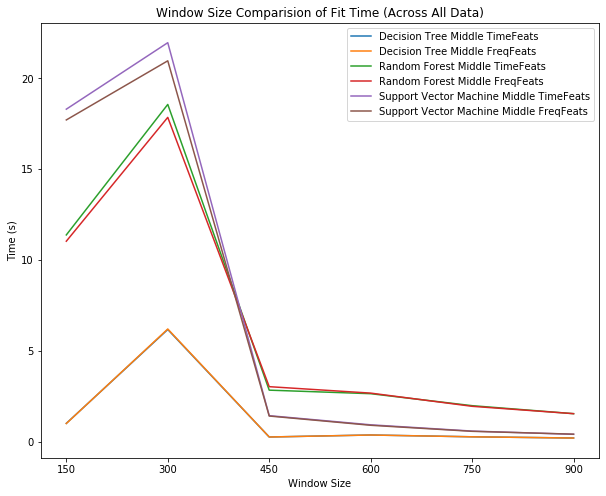

In [89]:
# Plot fit time
plot_sizes(classifier_names=['Decision Tree', 'Random Forest', 'Support Vector Machine'],
           placement_names=PLACEMENTS, vector_names=['TimeFeats', 'FreqFeats'],
           metric='fit_time')

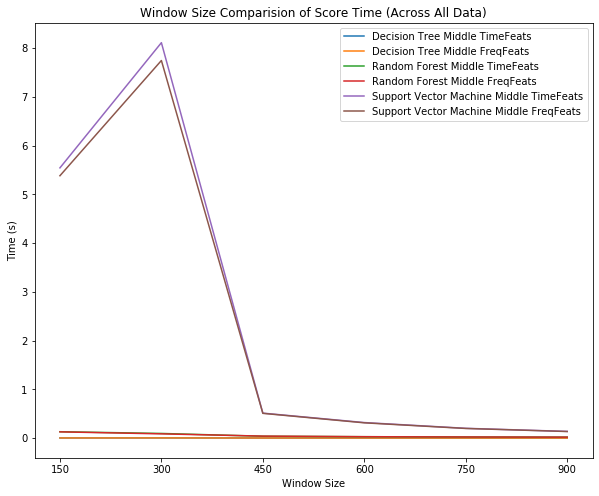

In [95]:
# Plot score time
plot_sizes(classifier_names=['Decision Tree', 'Random Forest', 'Support Vector Machine'],
           placement_names=PLACEMENTS, vector_names=['TimeFeats', 'FreqFeats'],
           metric='score_time')